## 9. 분류 실습 - 캐글 신용카드 사기 검출

#### 언더 샘플링과 오버 샘플링의 이해
: 지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해 적절한 학습 데이터를 확보하는 방안
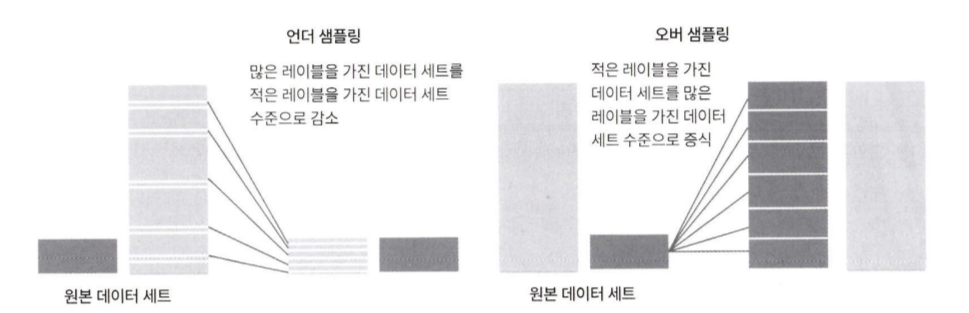
- 오버 샘플링: 예측 성능상 유리한 경우가 많아 주로 사용
  -  적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터 확보
  -  원본 데이터의 피처 값들을 약간 변경하여 증식 -> SMOTE 방법 이용
    - SMOTE: 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아 이 데이터와 K개의 이웃들의 차이를 일정값으로 생성  
      -> 기존 데이터와 약간 차이 나는 새로운 데이터 생성
      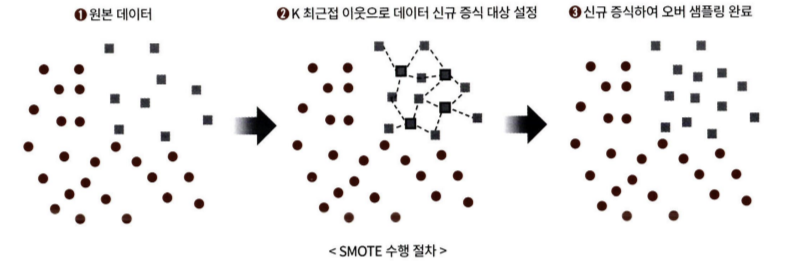
- 언더 샘플링
  - 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식
  - 너무 많은 정상 레이블을 감소 시켜버려 오히려 제대로된 학습을 수행할 수 없음.


#### 데이터 일차 가공 및 모델 학습/예측/평가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('./data/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


- get_preprocessed_df() 함수 정의: 불필요한 Time 피처만 삭제

In [2]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사한 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

- get_train_test_dataset(): get_preprocessed_df 호출 후, train-test data split

In [12]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수: train_test_split(test_size=0.3)
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들 
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할 
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [13]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.828453
1     0.171547
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.829122
1     0.170878
Name: count, dtype: float64


-> 큰 차이 없이 잘 분할 됨

- get_clf_eval 함수 호출

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
def get_clf_eval(y_test, pred=None, pred_proba=None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # roc_auc 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
    F1 : {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

- 로지스틱 회귀를 이용해 신용 카드 사기 여부 예측 + 성능 평가

In [15]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.8750, 재현율 : 0.6712,     F1 : 0.7597, AUC:0.9743


반복적으로 모델 변경해 학습/예측/평가를 위한 별도 함수 생성

In [16]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train,tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

- LightGBM으로 모델 학습 : 극도로 불균형한 레이블 값 분포도 -> boost_from_average=False

In [17]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   25   121]]
정확도 : 0.9996, 정밀도 : 0.9603, 재현율 : 0.8288,     F1 : 0.8897, AUC:0.9780


-> 로지스틱 회귀보다 재현율, ROC-AUC가 높은 수치 

#### 데이터 분포도 변환 후 모델 학습/예측/평가  
: 왜곡된 분포도 가지는 데이터 재가공 후 다시 테스트 
- 로지스틱 회귀: 선형 모델 -> 중요 피처 값이 정규분포 형태를 유지하는 것을 선호  
  *중요 속성 : Amount(신용카드 사용 금액-정상/사기 트랜잭션 결정)일 가능성 높음

<Axes: xlabel='Amount', ylabel='Density'>

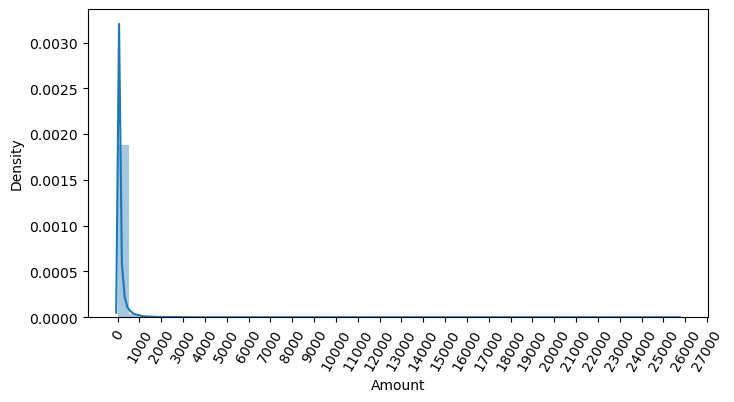

In [49]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

In [18]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    scaler = StandardScaler()
    amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

- get_train_test_dataset() -> 학습/테스트 데이터 세트 생성 후 
- get_model_train_eval() 이용 -> 로지스틱 회귀, LightGBM 모델 학습/예측/평가

In [19]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8654, 재현율 : 0.6081,     F1 : 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85095   200]
 [   67    81]]
정확도 : 0.9969, 정밀도 : 0.2883, 재현율 : 0.5473,     F1 : 0.3776, AUC:0.7724


- 성능 개선을 위해 로그 변환 수행: 분포도가 왜곡되어있을때, 적용하는 중요 기법

In [20]:
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n=np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

로그 변환 후 다시 로지스틱 회귀와 LGBM 모델 적용 -> 성능예측

In [21]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도 : 0.9992, 정밀도 : 0.8812, 재현율 : 0.6014,     F1 : 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85235    60]
 [   81    67]]
정확도 : 0.9983, 정밀도 : 0.5276, 재현율 : 0.4527,     F1 : 0.4873, AUC:0.7259


#### 이상치 데이터 제거 후 모델 학습/예측/평가
- 이상치 데이터: 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터 (=아웃라이어)
- 모델 성능에 영향 받는 경우가 많아 이상치 찾아내서 제거 후 모델 적용 및 평가가 필요
- 찾는 방법 : IQR 방식
  - IQR: 사분위 값의 편차를 이용하는 기법 -> 박스플롯으로 시각화
    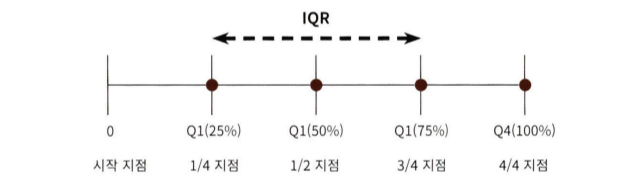
    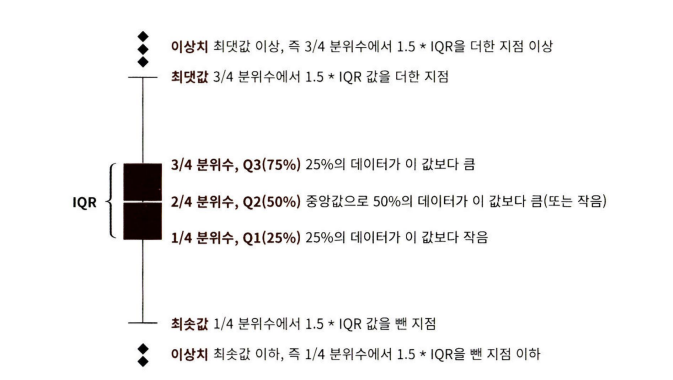

- 각 피처별 상관도 

<Axes: >

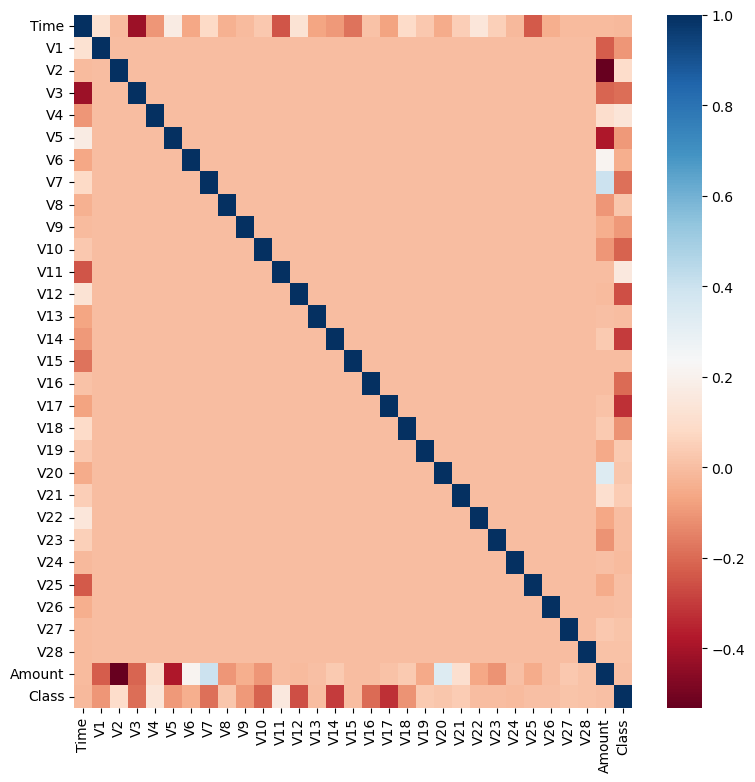

In [15]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

-> V14와 V17이 음의 상관 관계가 가장 높음 -> V14에 대해서 이상치 탐색 및 제거 진행 

In [22]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # frqud에 해당하는 column 데이터만 추출, 1/4qnsdnldhk 3/4분위 지점을 np.percentile로 구함.
    fraud = df[df['Class']==1][column]
    quantile_25=np.percentile(fraud.values,25)
    quantile_75=np.percentile(fraud.values,75)
    # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
    iqr=quantile_75-quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val=quantile_75 + iqr_weight
    # 최댓값보다 크거ㅏㄴ, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
    outlier_index=fraud[(fraud<lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [23]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [24]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    amount_n=np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled',amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.8750, 재현율 : 0.6712,     F1 : 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85268    27]
 [   36   110]]
정확도 : 0.9993, 정밀도 : 0.8029, 재현율 : 0.7534,     F1 : 0.7774, AUC:0.9219


#### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가  
: 학습 데이터 세트만 오버 샘플링 해야함 -> fit_sample() 매서드 이용 

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


로지스틱 회귀 모델 학습

In [26]:
lr_clf = LogisticRegression()
# ftr_train 과 tgt_train 인자 값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도 : 0.9723, 정밀도 : 0.0542, 재현율 : 0.9247,     F1 : 0.1023, AUC:0.9737


- precision_recall_curve_plot() 함수 정의: 분류결정 임곗값에 따른 정밀도와 재현율 곡선 시각화

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 PLot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize = (8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    # threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

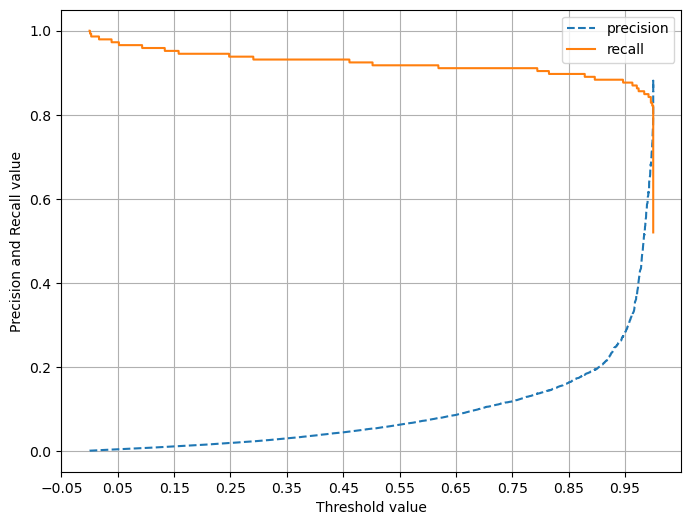

In [30]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

- LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가

In [31]:
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도 : 0.9996, 정밀도 : 0.9118, 재현율 : 0.8493,     F1 : 0.8794, AUC:0.9814


## 10. 스태킹 앙상블  
: 개별적 알고리즘을 서로 결합해 예측 결과 도출 -> 배깅, 부스팅과의 공통점  
: 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측 수행 -> 차이점  
*메타모델: 개별 모델의 예측된 데이터 세트를 기반으로 다시 학습하고 예측하는 방식
- 스태킹 모델  
  핵심: 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합    
      -> 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것  
  - 개별적인 기반 모델
  - 최종 메타 모델  
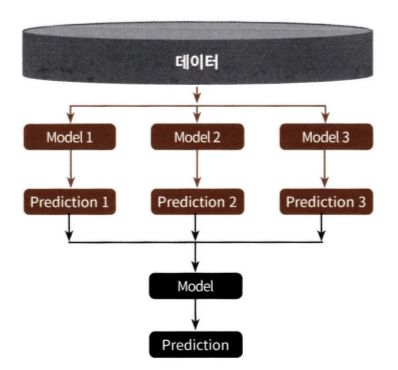
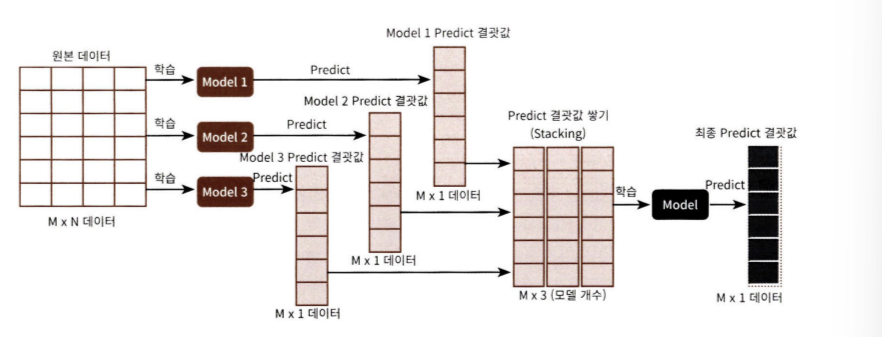


#### 기본 스태킹 모델

In [2]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data=cancer_data.data
y_label=cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

- 스태킹에 사용될 머신러닝 알고리즘 클래스 생성 
    - 개별 모델: KNN, 랜덤포레스트, 결정 트리, 에이다부스트
    - 최종모델: 로지스틱 회귀

In [4]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf= DecisionTreeClassifier()
ada_clf= AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

In [5]:
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [6]:
# 개별 모델들을 학습.
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)
#gbm_pred=gbm_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test,knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test,rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test,ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561


In [7]:
pred=np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환, 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [8]:
lr_final.fit(pred, y_test)
final=lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


####  CV 세트 기반의 스태킹
: 과적합 문제 개선을 위해 개별 모델들이 교차 검증으로 메타 모델을 위한 학습용 스태킹 데이터 생성과 예측을 위한 테스트용 스태킹 데이터를 생성한 뒤 이를 기반으로 메타 모델이 학습과 예측을 수행 
- Step 1: 각 모델별 원본 학습/테스트 데이터 예측 결과값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터 생성
- Step 2 : step1에서 개별 모델이 생성한 학습용 데이터를 모두 스태킹 형태로 합침 -> 메타 모델이 학습할 최종 학습용 데이터 세트 생성  
  ->테스트 데이터 세트도 동일하게 생성  
  -> 메타모델: 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성한 테스트 데이터 세트 예측, 원본 테스트 데이터의 레이블 데이터를 기반으로 평가

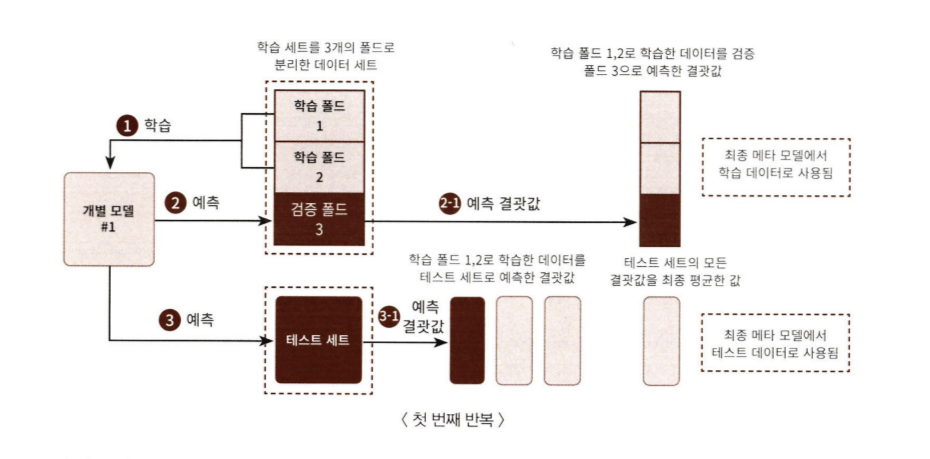
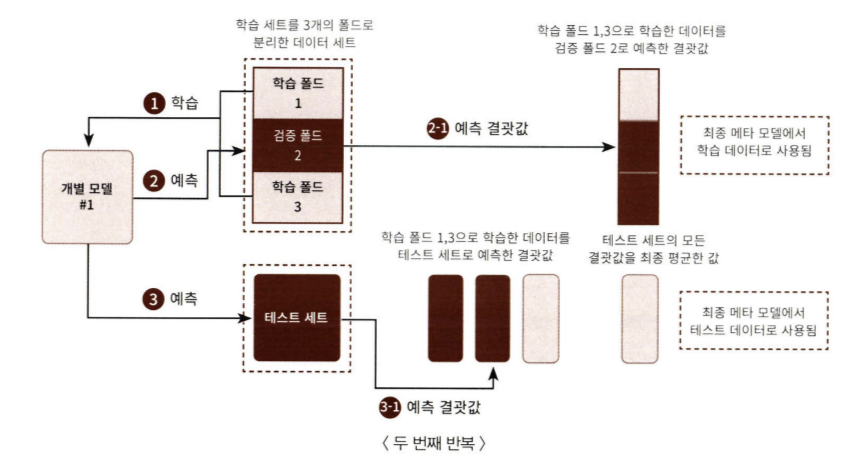
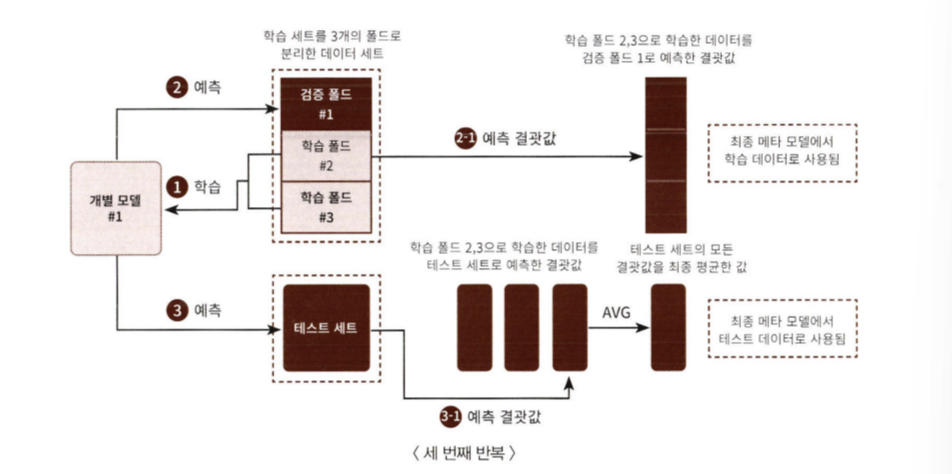
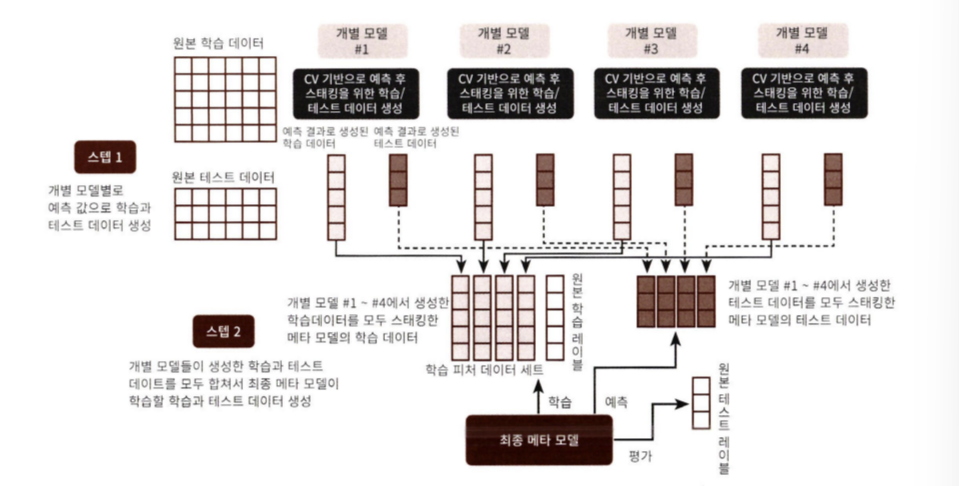

In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds 값으로 KFold 생성.
    # kf = KFold(n_splits=n_folds, shuffle=False, random_state=0) -> error : 오류 발생 
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros(X_test_n.shape[0], n_folds)
    print(model.___class__.__name__, 'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [9]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

TypeError: Cannot interpret '7' as a data type

In [50]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
pirnt('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape, 
      '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

NameError: name 'knn_train' is not defined

In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정혹도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

## 11. 정리
- 앙상블: 결정 트리 기반의 다수의 약한 학습기 결합 -> 변동성 줄여 예측 올 줄이고 성능 개선
- 결정 트리 알고리즘 : 정보의 균일도 기반한 규칙 트리 생성-> 예측 수행  
  -> 직관적, 과정을 쉽게 알아볼 수 O, 과적합 문제 발생
  - 배깅: 학습 데이터를 중복으로 허용 -> 다수의 세트 샘플링 -> 다수의 약한 학습기가 학습 -> 최정결과 결합+예측
    - 랜덤 포레스트: 수행시간이 빠르고 비교적 안정적인 예측 성능 제공
  - 부스팅: 학습기들이 순차적으로 학습 진행 -> 예측 틀린 데이터에 가중치 부여 -> 다음번 학습기가 학습할 때 이전에 옟ㄱ이 틀린 데이ㅓ에 대해 보다 높은 정확도로 예측할 수 있음
    - XGBoost
    - LightGBM
- 스태킹 모델: 여러개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터 세트와 예측할 데이터 세트를 재생성하는 기법